In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use("fivethirtyeight")
BASE_DF = pd.read_csv('./AlgerianFF_Region1.csv')
BASE_DF.merge( pd.read_csv('./AlgerianFF_Region2.csv') )
BASE_DF.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5


In [2]:
def get_random_sample():
    return BASE_DF.sample(frac=1).reset_index(drop=True)
# Sanity check it gets a random stample
print(get_random_sample().head())
print(get_random_sample().head())


   day  month  year  Temperature   RH   Ws  Rain   FFMC   DMC     DC  ISI  \
0   25      6  2012           31   64   15    0.0  86.7  14.2   63.8  5.7   
1   20      7  2012           33   65   15    0.1  81.4  12.3   62.1  2.8   
2    5      7  2012           33   66   14    0.0  85.9   7.6   27.9  4.8   
3   30      8  2012           35   70   17    0.8  72.7  25.2  180.4  1.7   
4   25      8  2012           35   60   15    0.0  88.9  43.9  181.3  8.2   

    BUI   FWI  
0  18.3   8.4  
1  16.5   4.0  
2   9.1   4.9  
3  37.4   4.2  
4  54.7  20.3  
   day  month  year  Temperature   RH   Ws  Rain   FFMC   DMC    DC  ISI  \
0   16      9  2012           30   65   14    0.0  78.1   3.2  15.7  1.9   
1   29      6  2012           32   47   13    0.3  79.9  18.4  84.4  2.2   
2    7      7  2012           35   64   18    0.2  80.0   9.7  40.4  2.8   
3    8      6  2012           30   73   15    0.0  86.6  12.1  38.3  5.6   
4   12      9  2012           29   88   13    0.0  71.0   2.6

In [3]:
# Helper function to see the output of predictions
def print_predictions(regressor):
    for i in range(len(X_test)):
        print(f"{regressor.predict([X_test[i]])[0]}\t{y_test[i]}")

# Calculate the mean absolute error
def calcMeanABSError(regressor, xs, ys):
    total = 0
    for i in range(len(xs)):
        prediction = regressor.predict([xs[i]])[0]
        actual = ys[i]
        total += abs(prediction - actual)
    return total / len(xs)
    

In [4]:
from sklearn.ensemble import RandomForestRegressor
def train_RFR(X_train, y_train):
    return RandomForestRegressor().fit(X_train, y_train)

In [5]:
from sklearn.neural_network import MLPRegressor
def train_MLP(X_train, y_train):
    return MLPRegressor(max_iter=1500).fit(X_train, y_train)

In [6]:
from sklearn.svm import SVR
def train_SVR(X_train, y_train):
    return SVR().fit(X_train, y_train)

In [7]:
def iterate(df, results, index):
    y = np.array(df['FWI'])
    # Drop target (FWI) from training data
    # Drop day and year as they won't help
    # Month is left in as the month could be a predictor of a forest fire
    df = df.drop(['FWI', 'day', 'year'], axis=1) 
    inputs = np.array(df, float)
    X = preprocessing.scale(inputs)

    split_point = math.floor(len(X) * 0.7) # 70% train / 30% test

    X_train, X_test = X[split_point:], X[split_point + 1: ]
    y_train, y_test = y[split_point:], y[split_point + 1: ]

    regressors = [
        train_RFR(X_train, y_train),
        train_MLP(X_train, y_train),
        train_SVR(X_train, y_train)
    ]

    mae = []
    for regr in regressors:
        mae.append(calcMeanABSError(regr, X_test, y_test))
    results[index] = mae

100%|██████████| 128/128 [01:33<00:00,  1.37it/s]


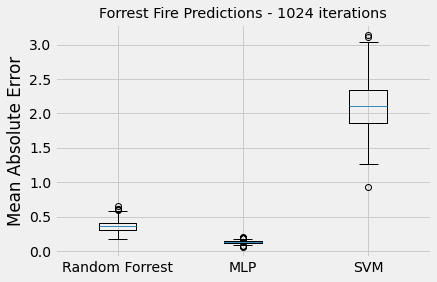

In [8]:
import multiprocessing
import tqdm

manager = multiprocessing.Manager()
results = manager.dict()
jobs = []
n_threads = 8
ITERS= 1024 # Has to be divisable by n_threads
RFR_mae = []
MLP_mae = []
SVR_mae = []

# Basic threadding so I can do more cross validation faster
# Run in batches of n_threads
for _ in tqdm.tqdm(range(0, ITERS, n_threads)):
    for i in range(n_threads):
        # Create a new worker thread
        p = multiprocessing.Process(target=iterate, args=(get_random_sample(), results, i))
        jobs.append(p)
        p.start()
    for proc in jobs:
        # Join all the threads
        proc.join()
    for result in results.values():
        # Once all the threads are joined, extract the data
        RFR_mae.append(result[0])
        MLP_mae.append(result[1])
        SVR_mae.append(result[2])




plt.boxplot([RFR_mae, MLP_mae, SVR_mae])
plt.style.use("ggplot")
plt.title(f"Forrest Fire Predictions - {ITERS} iterations")
plt.xticks([1, 2, 3], ['Random Forrest', 'MLP', 'SVM'])
plt.ylabel("Mean Absolute Error")
plt.show()
